## 1. 패키지 불러오기

#### 설치가 되지 않은 패키지는 anaconda에서 pip install로 설치가능합니다.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt
import os
from tqdm import tqdm
import re
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import gensim.corpora as corpora
import gensim
from gensim import models
import pyLDAvis.gensim 
from nltk import bigrams

In [2]:
import matplotlib.font_manager as fm
from matplotlib import rc
font_name = fm.FontProperties(fname="c:/Windows/Fonts/H2GTRE.ttf").get_name()
rc('font', family=font_name)

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2. 데이터 불러오기

In [12]:
data_path = './data/kakaoreview.csv'
data_format = 'csv'

In [13]:
if data_format == 'csv':
    data = pd.read_csv(data_path, encoding = 'utf-8')
elif data_format == 'xlsx':
    data = pd.read_excel(data_path)
else:
    raise Exception('This format is not supported. [Must be [csv, xlsx]')
data.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,0,ac0fbabd-8ee3-4819-81fb-b3ffa8a296dd,김정선,https://play-lh.googleusercontent.com/a/AGNmyx...,카카오블루를 부르는 이유는 택시를 빨리 잡아 목적지에 빨리 도달하기 위해서인데 주변...,1,0,NaN,2023-05-03,NaN
1,1,1e723c87-9a05-49d5-aa2f-303adeaea3bf,박블리,https://play-lh.googleusercontent.com/a/AGNmyx...,좋은어플이에요,5,0,6.2.1,2023-05-03,6.2.1
2,2,6d247505-e723-40cf-9fad-7cde6806082c,강대한애국당,https://play-lh.googleusercontent.com/a/AGNmyx...,ㅌ66 ㅣ기4ㄴㄱㄴㄱ#2-+`1+-+!Qwzwzasqzaㅣㅇ비비zw1ssQㅣㅋㅋ1a...,3,0,5.12.1,2023-05-03,5.12.1
3,3,19be772b-c5c0-404b-939a-6bf8bd9b5578,Gangmin Kim,https://play-lh.googleusercontent.com/a/AGNmyx...,카카오는 왜 기업이 독점을 하면서 서비스가 항상 밥찌꺼기같은지 모르겠네요 왜 자꾸 ...,1,0,6.2.1,2023-05-03,6.2.1
4,4,2890cae1-b71f-4312-8126-423e6c5de920,치천후TV,https://play-lh.googleusercontent.com/a-/ACB-R...,자전거 자주이용하고잇엇는데 3일 전부터 거리에 쉽게 찾을수잇던 카카오바이크가 검색창...,1,0,NaN,2023-05-02,NaN


## 3. 텍스트 전처리

### (1) Define Pre-processing Parameters.

In [26]:
Okt = Okt()

In [21]:
text_col = 'content'
extract_pos = ['Noun', 'Adjective', 'Verb', 'Alpha'] # Noun: 명사, Adjective: 형용사, Verb: 동사, Alpha: 영어
stopwords = ['대한', '위해', '첫째', '둘째', '또한','있다', '없다', '아니다', '같다']
minumum_character = 2

In [22]:
def my_tokenizer(doc, minumum_character):
    tokens = [token for token, pos in Okt.pos(doc, norm=True, stem=True) if pos in extract_pos] # 토큰화
    tokens = [word for word in tokens if (word not in stopwords)] # 불용어 제거
    tokens = [word for word in tokens if (len(word) > minumum_character)]# minumum_character 글자 이상의 단어만
    return tokens

### (2) 사전 처리 (선택적 사용)

#### (a) 영어 제거  

In [16]:
def remove_english(text):
    text = re.sub('[a-zA-z]','',text)
    return text

data[text_col] = data[text_col].map(remove_english)

#### (b) 합성어 단어 변환

In [34]:
comb_words = []

#### - Bigram 을 활용하여 합성어 목록 갱신

In [27]:
Token = [my_tokenizer(sentence) for sentence in tqdm(data[text_col])]

100%|██████████| 3000/3000 [00:26<00:00, 115.19it/s]


In [28]:
bigram = [list(bigrams(token)) for token in Token]
merged = list(itertools.chain(*bigram))
bigram_count = Counter(merged)

In [31]:
merging_N = 50
selected_bigrams = bigram_count.most_common(merging_N)
selected_bigrams

[(('잡히다', '잡히다'), 65),
 (('카카오', '바이크'), 27),
 (('안녕하다', '선생님'), 25),
 (('선생님', '안녕하다'), 24),
 (('부르다', '잡히다'), 23),
 (('카카오', '카카오'), 23),
 (('카카오', '잡히다'), 21),
 (('잡히다', '부르다'), 20),
 (('안되다', '안되다'), 20),
 (('잡히다', '카카오'), 19),
 (('가깝다', '잡히다'), 18),
 (('카카오', '부르다'), 16),
 (('잡히다', '기다리다'), 15),
 (('건지다', '모르다'), 14),
 (('카카오', '안되다'), 13),
 (('더럽다', '잡히다'), 13),
 (('나오다', '잡히다'), 12),
 (('안되다', '카카오'), 12),
 (('드럽다', '잡히다'), 12),
 (('잡히다', '만들다'), 11),
 (('돌아가다', '나오다'), 11),
 (('로그인', '안되다'), 11),
 (('수수료', '카카오'), 11),
 (('고르다', '태우다'), 10),
 (('별하나', '아깝다'), 10),
 (('누르다', '잡히다'), 10),
 (('잡히다', '그렇다'), 10),
 (('잡히다', '건지다'), 9),
 (('잡히다', '걸리다'), 9),
 (('잡히다', '안되다'), 9),
 (('잡히다', '짜증나다'), 9),
 (('건지다', '건지다'), 8),
 (('급하다', '부르다'), 8),
 (('카카오', '그렇다'), 8),
 (('제대로', '해주다'), 8),
 (('잡히다', '나오다'), 8),
 (('안되다', '부르다'), 8),
 (('이렇다', '만들다'), 8),
 (('누르다', '누르다'), 8),
 (('기다리다', '기다리다'), 8),
 (('비싸다', '잡히다'), 8),
 (('안되다', '잡히다'), 8),
 (('단거리', '잡히다'), 8),
 (('카카오', '지나가다'), 8

In [32]:
selected_bigrams = [bg for (bg, cnt) in selected_bigrams]
comb_words = [[''.join(bg), ' '.join(bg)] for bg in selected_bigrams] + comb_words

#### - 사용자 베이스 합성어 정의

In [36]:
custom_comb_words = [['카카오자전거', '카카오 자전거']]
comb_words = comb_words + custom_comb_words

#### - 대체하기

In [38]:
def Word_transform(Text, word_list, to_word):
    for word in word_list:
        Text = str(Text).replace(word,to_word)
    return Text

Transform_words = [' ' + 'TRSF' * (i+1) + ' ' for i in range(len(comb_words))]
Transform_words[0:3]

for i in range(len(comb_words)):
    data[text_col] = [Word_transform(txt, comb_words[i], Transform_words[i]) for txt in data[text_col]]    

[' TRSF ']

### (3) Tokenize

In [41]:
extract_pos = ['Noun', 'Adjective', 'Verb', 'Alpha']
Token = [my_tokenizer(sentence) for sentence in tqdm(data[text_col])]

100%|██████████| 3000/3000 [00:21<00:00, 137.60it/s]


#### - 합성어 복원

In [42]:
def Word_restore(Text, word1, word2):
    transformed_list = []
    for word in Text:
        if word1 in word:
            word = word2
        transformed_list.append(word)
    return transformed_list

restore_words = [word_list[0] for word_list in comb_words]

Transform_words.reverse()
restore_words.reverse()


for i in range(len(restore_words)):
    Token = [Word_restore(token, Transform_words[i][1:-1], restore_words[i]) for token in Token] 
Token[0:3]

[['카카오',
  '부르다',
  '목적지',
  '기다리다',
  '수수료',
  '그대로',
  '나가다',
  '기다리다',
  '목적지',
  '건지다',
  '건지다',
  '막히다',
  '다시다'],
 [],
 []]

## 4. 빈도 분석

In [43]:
os.makedirs('./빈도분석', exist_ok = True)

In [44]:
def visulize(noun_list, filename, white = True):
    if white == True:
        wordcloud = WordCloud(width=2000, height=1000, font_path = "c:/Windows/Fonts/H2GTRE.ttf", collocations=True, background_color='white')
    else:
        wordcloud = WordCloud(width=2000, height=1000, font_path = "c:/Windows/Fonts/H2GTRE.ttf", collocations=True)
    wordcloud.generate_from_frequencies(dict(noun_list))
    wordcloud.to_file(filename)

In [45]:
def wordcloud_Rank(token, N = 30, white = True):
    filename = os.path.join('./빈도분석', 'keyword_wordcloud.png')
    filename_csv = os.path.join('./빈도분석', 'keyword_count.csv')
    
    flatten_tokens = list(itertools.chain(*token))
    token_count = Counter(flatten_tokens)
    Top_token_count = token_count.most_common(N)
    
    Top_token_count_df = token_count.most_common(1000)
    word_count = pd.DataFrame(Top_token_count_df)
    word_count.columns = ['Word', 'Count']
    word_count.to_csv(filename_csv, index = False, encoding='euc-kr')
    
    visulize(Top_token_count, filename, white)
    return word_count

In [46]:
word_count = wordcloud_Rank(Token, 100, white = True)
word_count.head(30)

/home/jongwook95.lee/miniforge3/envs/topic_model/lib/python3.8/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


OSError: cannot open resource

## 5. 토픽 분석

In [47]:
id2word=corpora.Dictionary(Token)
id2word.filter_extremes(no_below = 3) #3회 이하로 등장한 단어는 삭제
texts = Token
corpus=[id2word.doc2bow(text) for text in texts]

os.makedirs('./토픽분석', exist_ok = True)

### (1) 토픽모델링 결과 확인

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
    plt.savefig('./토픽분석/토픽개수선정.png')
    plt.show()
    
    return model_list, coherence_values

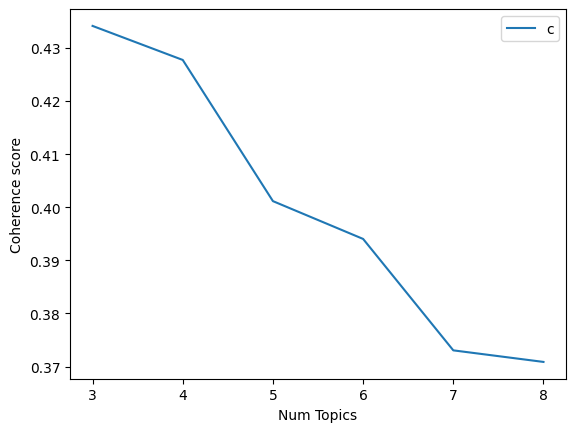

In [49]:
start_topic_num = 3
end_topic_num = 8
step = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start_topic_num, limit=end_topic_num+1, step=step)

In [50]:
best_topic_num = range(start_topic_num, end_topic_num+1, step)[coherence_values.index(max(coherence_values))]
print("Best topic number: {}".format(best_topic_num))

Best topic number: 3


In [51]:
best_model = model_list[coherence_values.index(max(coherence_values))]

In [52]:
#best_model = model_list[coherence_values.index(max(coherence_values))]
topics = best_model.print_topics(num_words=8) 
topics

[(0,
  '0.045*"해주다" + 0.037*"쓰레기" + 0.031*"누르다" + 0.027*"부르다" + 0.025*"가깝다" + 0.021*"이상하다" + 0.018*"짜증나다" + 0.018*"바뀌다"'),
 (1,
  '0.098*"카카오" + 0.069*"안되다" + 0.032*"서비스" + 0.026*"걸리다" + 0.022*"만들다" + 0.021*"바이크" + 0.020*"기다리다" + 0.020*"나오다"'),
 (2,
  '0.174*"잡히다" + 0.040*"카카오" + 0.026*"부르다" + 0.026*"기다리다" + 0.019*"편하다" + 0.019*"해주다" + 0.016*"나오다" + 0.015*"안되다"')]

In [53]:
topic_words = dict()

for i in range(best_topic_num):
    words = [word for (word, prob) in best_model.show_topic(i, 20)]
    topic_words['Topic_' + str(i + 1)] = words
    
topic_words = pd.DataFrame(topic_words)

topic_words.to_excel(os.path.join('./토픽분석', 'Topic Words.xlsx'), index = False)
topic_words.head(10)

,Topic_1,Topic_2,Topic_3
0,해주다,카카오,잡히다
1,쓰레기,안되다,카카오
2,누르다,서비스,부르다
3,부르다,걸리다,기다리다
4,가깝다,만들다,편하다
5,이상하다,바이크,해주다
6,짜증나다,기다리다,나오다
7,바뀌다,나오다,안되다
8,돌아가다,모르다,돌아가다
9,편하다,그렇다,그렇다


In [54]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, os.path.join('./토픽분석', 'Topic Plot.html'))

/home/jongwook95.lee/miniforge3/envs/topic_model/lib/python3.8/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## 6. TF-IDF

In [59]:
def get_tf_idf(Token):
    sentences = [' '.join(token) for token in Token]
    
    ## (1) 전체 문서의 수 계산
    doc_num = len(sentences)
    
    ## (2) Term-document Matrix 정의하기
    cv = CountVectorizer()
    tdm = cv.fit_transform(sentences)
    tdm = tdm.toarray()
    
    ## (3) 해당 단어의 총 Count 계산 (Term-document Matrix에서 Row sum 을 하면 계산 가능)
    words = cv.get_feature_names_out()
    word_count = tdm.sum(axis=0)
    
    ## (4) 해당 단어가 들어있는 문서의 수 계산 (Term-document Matrix의 값 중에서 1보다 큰경우 해당 단어가 있는 것이므로, 1보다 큰 경우를 1로 바꾸거 Row sum)
    tdm[tdm > 1] = 1
    word_doc = tdm.sum(axis=0)
    
    ## (5) TF-IDF 계산
    tf = word_count / doc_num
    idf = np.log(doc_num / word_doc)
    tf_idf = tf * idf
    
    ## (6) DataFrame으로 만들기
    TF_IDF = pd.DataFrame({'Word': words, 'TF': tf, 'IDF': idf, 'TF-IDF': tf_idf})
    TF_IDF = TF_IDF.sort_values(by = 'TF-IDF', ascending = False).reset_index(drop = True)
    return TF_IDF

In [61]:
tf_idf_df = get_tf_idf(Token)
tf_idf_df.head()

,Word,TF,IDF,TF-IDF
0,잡히다,0.264333,1.617806,0.427640
1,카카오,0.177000,1.966113,0.348002
2,안되다,0.117000,2.343407,0.274179
3,부르다,0.067333,2.876469,0.193682
4,해주다,0.060000,2.937463,0.176248


In [62]:
os.makedirs('./TF_IDF', exist_ok = True)
tf_idf_df.to_csv('./TF_IDF/tf_idf.csv', index = False, encoding = 'euc-kr')

## 7. Keyword Network

In [63]:
def min_max(x):
    return (x-min(x)) / (max(x) - min(x))

def make_Co_Keyword(Text):
    Co_Keyword = list(itertools.combinations(Text,2))
    Co_Keyword = [tuple(sorted((x,y))) for (x,y) in Co_Keyword if x != y]
    return Co_Keyword

def make_Edgelist(Token):
    Co_Keyword = [make_Co_Keyword(list(set(text))) for text in Token]
    Co_Keyword = list(itertools.chain(*Co_Keyword))
    Edge_list = list((x, y, v) for (x,y), v in Counter(Co_Keyword).items())
    return Edge_list

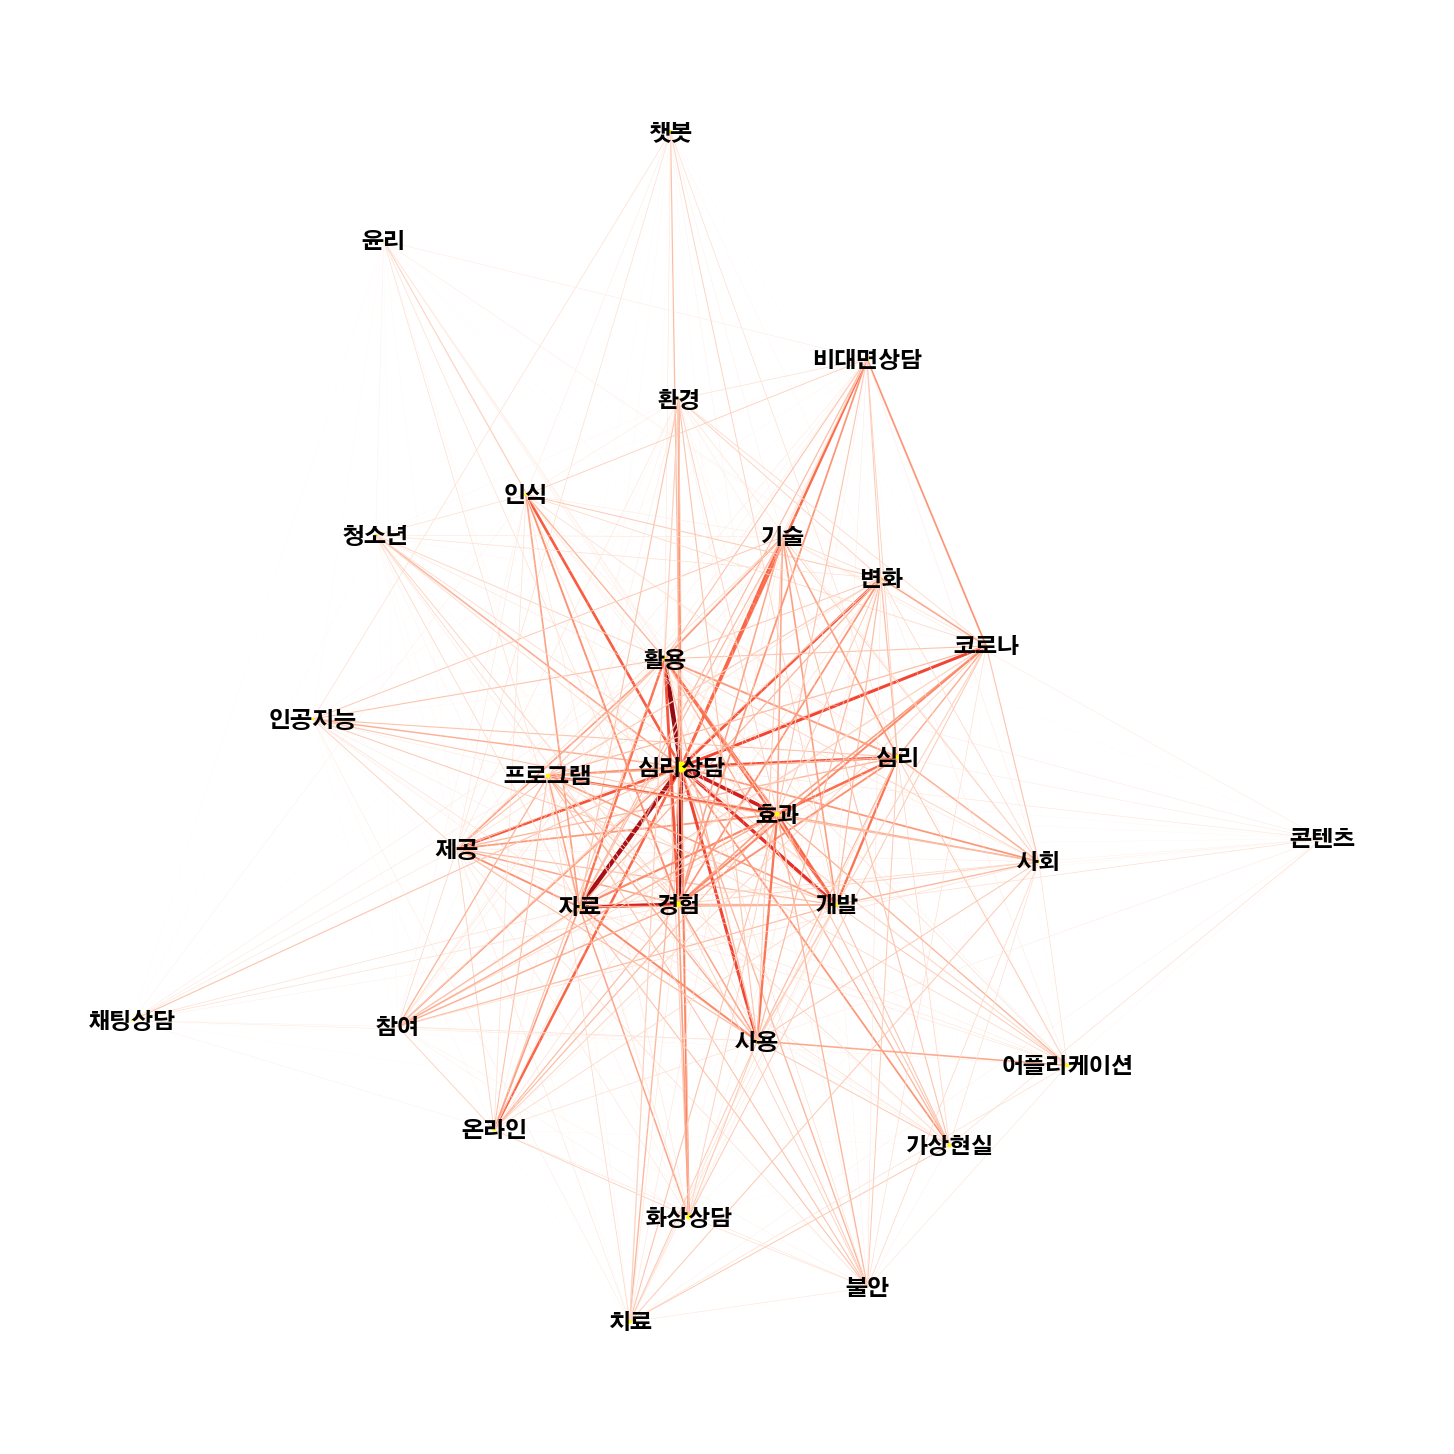

In [493]:
N = 30

flatten_tokens = list(itertools.chain(*Token))
## 상위 노출 키워드 리스트 추출
All_words = Counter(flatten_tokens)
Top_words = All_words.most_common(N)
Top_words = [word for (word, count) in Top_words]
Edge_list = make_Edgelist(Token)
## 그래프 생성
Top_Edge_list = list((x, y, v) for (x,y,v) in Edge_list if (x in Top_words and  y in Top_words))
G_top = nx.Graph()
for A,B, weight in Top_Edge_list: G_top.add_edge(A, B, weight=weight, distance = 1/weight)
width_top = list(nx.get_edge_attributes(G_top, 'weight').values())
degree = [All_words[node] * 60 for node in list(G_top.nodes)]
edges_top = G_top.edges()
weights = [G_top[u][v]['weight'] for u,v in edges_top]
    
## 시각화 Weight 설정
weights = min_max(np.array(weights))
degree = min_max(np.array(degree))
weights = [wei * 5  for wei in weights]
degree = [deg * 100  for deg in degree]

import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/H2GTRE.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

plt.figure(figsize=(20,20))
pos = nx.spring_layout(G_top, k = 0.5)
nx.draw(G_top, pos, width=weights, node_color= 'yellow', node_size = degree, edge_color=weights, edge_cmap=plt.cm.Reds)
nx.draw_networkx_labels(G_top, pos, font_size=22, font_color='black', font_family = font_name)
os.makedirs('./Keyword', exist_ok = True)
plt.savefig('./Keyword/word_network.png')